# 1. Improving the quality of synthesized images using a convolutional and Wasserstein GAN
## Basic imports

In [3]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


print(tf.__version__)

print("GPU Available:", tf.test.is_gpu_available())

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()

else:
    device_name = 'CPU:0'
    
print(device_name)

## 1. Define helper functions to create the necessary parts of the network
- The main difference between WGAN and traditional GAN is the inclusion of Trasposed convolution and Convolution layers, which allow the network to benefit from the same feature capture improvements that can be observed when comparing traditional NNs and CNNs for image classification tasks
- The architecture also takes advantage of BatchNorm layers: one of the main ideas behind BatchNorm is normalizing the layer inputs and preventing changes in their distribution during training, which enables faster and better convergence (in 2018 study by S. Santurkar and others, the researchers hypothesized that the effectiveness of BatchNorm is based on a smoother surface of the loss function, which makes the non-convex optimisation more robust)

### 1. Define the helper functions

In [4]:
def make_dcgan_generator(
        z_size=20, 
        output_size=(28, 28, 1),
        n_filters=128, 
        n_blocks=2):
    size_factor = 2**n_blocks
    hidden_size = (
        output_size[0]//size_factor, 
        output_size[1]//size_factor
    )
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(z_size,)),
        
        tf.keras.layers.Dense(
            units=n_filters*np.prod(hidden_size), 
            use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape(
            (hidden_size[0], hidden_size[1], n_filters)),
    
        tf.keras.layers.Conv2DTranspose(
            filters=n_filters, kernel_size=(5, 5), strides=(1, 1),
            padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
        
    nf = n_filters
    for i in range(n_blocks):
        nf = nf // 2
        model.add(
            tf.keras.layers.Conv2DTranspose(
                filters=nf, kernel_size=(5, 5), strides=(2, 2),
                padding='same', use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
                
    model.add(
        tf.keras.layers.Conv2DTranspose(
            filters=output_size[2], kernel_size=(5, 5), 
            strides=(1, 1), padding='same', use_bias=False, 
            activation='tanh'))
        
    return model

def make_dcgan_discriminator(
        input_size=(28, 28, 1),
        n_filters=64, 
        n_blocks=2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size),
        tf.keras.layers.Conv2D(
            filters=n_filters, kernel_size=5, 
            strides=(1, 1), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
    
    nf = n_filters
    for i in range(n_blocks):
        nf = nf*2
        model.add(
            tf.keras.layers.Conv2D(
                filters=nf, kernel_size=(5, 5), 
                strides=(2, 2),padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.3))
        
    model.add(tf.keras.layers.Conv2D(
            filters=1, kernel_size=(7, 7), padding='valid'))
    
    model.add(tf.keras.layers.Reshape((1,)))
    
    return model

### 2. Check that the helper functions actually create models as expected

In [5]:
gen_model = make_dcgan_generator()
gen_model.summary()

disc_model = make_dcgan_discriminator()
disc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              125440    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

## 2. Get the MNIST dataset and define the preprocessing function

In [6]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


## 3. Define the training parameters and set-up the model

In [7]:
num_epochs = 100
batch_size = 128
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
lambda_gp = 10.0

tf.random.set_seed(1)
np.random.seed(1)

## Set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## Set-up the model
with tf.device(device_name):
    gen_model = make_dcgan_generator()
    gen_model.build(input_shape=(None, z_size))
    gen_model.summary()

    disc_model = make_dcgan_discriminator()
    disc_model.build(input_shape=(None, np.prod(image_size)))
    disc_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              125440    
_________________________________________________________________
batch_normalization_7 (Batch (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 128)        

## 4. Train the model using the available Google Colab GPU

In [8]:
import time


## optimizers:
g_optimizer = tf.keras.optimizers.Adam(0.0002)
d_optimizer = tf.keras.optimizers.Adam(0.0002)

if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

all_losses = []
epoch_samples = []

start_time = time.time()

for epoch in range(1, num_epochs+1):
    epoch_losses = []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## Compute discriminator's loss and gradients:
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            g_output = gen_model(input_z, training=True)
            
            d_critics_real = disc_model(input_real, training=True)
            d_critics_fake = disc_model(g_output, training=True)

            ## Compute generator's loss:
            g_loss = -tf.math.reduce_mean(d_critics_fake)

            ## Compute discriminator's losses
            d_loss_real = -tf.math.reduce_mean(d_critics_real)
            d_loss_fake =  tf.math.reduce_mean(d_critics_fake)
            d_loss = d_loss_real + d_loss_fake

            ## Gradient penalty:
            with tf.GradientTape() as gp_tape:
                alpha = tf.random.uniform(
                    shape=[d_critics_real.shape[0], 1, 1, 1], 
                    minval=0.0, maxval=1.0)
                interpolated = (
                    alpha*input_real + (1-alpha)*g_output)
                gp_tape.watch(interpolated)
                d_critics_intp = disc_model(interpolated)
            
            grads_intp = gp_tape.gradient(
                d_critics_intp, [interpolated,])[0]
            grads_intp_l2 = tf.sqrt(
                tf.reduce_sum(tf.square(grads_intp), axis=[1, 2, 3]))
            grad_penalty = tf.reduce_mean(tf.square(grads_intp_l2 - 1.0))
        
            d_loss = d_loss + lambda_gp*grad_penalty
        
        ## Optimization: Compute the gradients apply them
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
        
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
                    
    all_losses.append(epoch_losses)
    
    print('Epoch {:-3d} | ET {:.2f} min | Avg Losses >>'
          ' G/D {:6.2f}/{:6.2f} [D-Real: {:6.2f} D-Fake: {:6.2f}]'
          .format(epoch, (time.time() - start_time)/60, 
                  *list(np.mean(all_losses[-1], axis=0)))
    )
    
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy()
    )

Epoch   1 | ET 1.11 min | Avg Losses >> G/D 249.00/-412.49 [D-Real: -257.32 D-Fake: -249.00]
Epoch   2 | ET 2.12 min | Avg Losses >> G/D 194.76/-160.18 [D-Real: -129.90 D-Fake: -194.76]
Epoch   3 | ET 3.14 min | Avg Losses >> G/D 151.91/-50.18 [D-Real: -49.61 D-Fake: -151.91]
Epoch   4 | ET 4.15 min | Avg Losses >> G/D 104.36/ -0.00 [D-Real:   5.62 D-Fake: -104.36]
Epoch   5 | ET 5.16 min | Avg Losses >> G/D  85.17/  3.53 [D-Real:   2.92 D-Fake: -85.17]
Epoch   6 | ET 6.18 min | Avg Losses >> G/D  63.27/ -4.52 [D-Real:  18.54 D-Fake: -63.27]
Epoch   7 | ET 7.19 min | Avg Losses >> G/D  89.00/-36.56 [D-Real:  40.65 D-Fake: -89.00]
Epoch   8 | ET 8.21 min | Avg Losses >> G/D 128.19/-47.36 [D-Real:  73.05 D-Fake: -128.19]
Epoch   9 | ET 9.22 min | Avg Losses >> G/D 109.39/-43.89 [D-Real:  37.21 D-Fake: -109.39]
Epoch  10 | ET 10.23 min | Avg Losses >> G/D 108.90/-49.45 [D-Real:  45.91 D-Fake: -108.90]
Epoch  11 | ET 11.25 min | Avg Losses >> G/D 113.03/-53.17 [D-Real:  31.50 D-Fake: -113.

## 5. Save the model (ignore if not on Google Collab)

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [12]:
import pickle
pickle.dump({'all_losses':all_losses, 
            'samples':epoch_samples}, 
            open('/content/drive/My Drive/Colab Notebooks/ch17-WDCGAN-learning.pkl', 'wb'))

gen_model.save('/content/drive/My Drive/Colab Notebooks/ch17-WDCGAN-gan_gen.h5')
disc_model.save('/content/drive/My Drive/Colab Notebooks/ch17-WDCGAN-gan_disc.h5')

## 6. Visualize the results
### 1. Visualize the loss history

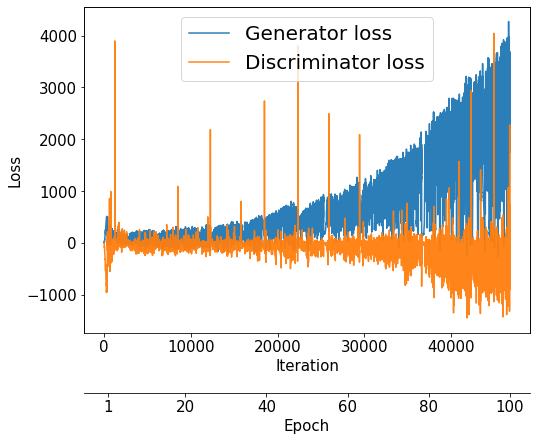

In [13]:
import itertools


fig = plt.figure(figsize=(8, 6))

## Plotting the losses
ax = fig.add_subplot(1, 1, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1] for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos   = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

#plt.savefig('images/ch17-wdcgan-learning-curve.pdf')
plt.show()

### 2. Visualize a few generated exmaples from different stages of training

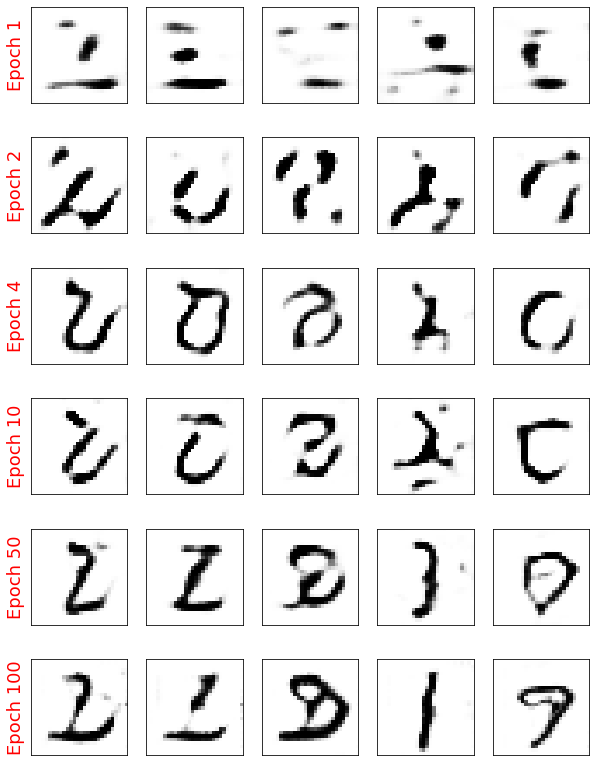

In [15]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.show()